In [1]:
!pip install torch_geometric

In [2]:
import json

In [3]:
hetnet_path = '/content/drive/MyDrive/KOBBY/Datasets/hetionet-v1.0.json'

with open(hetnet_path, 'r') as file:
  data = json.load(file)

In [4]:
import pandas as pd

nodes = data['nodes']
edges = data['edges']

nodes_df = pd.DataFrame(nodes)
edges_df = pd.DataFrame(edges)

# nodes_red = nodes_df[nodes_df['kind'].isin(['Side Effect', 'Disease', 'Symptom', 'Compound'])].reset_index(drop=True)
# print(f'Nodes: {nodes_red.shape}')

# valid_nodes = set(nodes_red['identifier'])

edges_df['s_id'] = edges_df['source_id'].apply(lambda x: x[1])
edges_df['t_id'] = edges_df['target_id'].apply(lambda x: x[1])

# filtered_edges = edges_df[
#     edges_df['s_id'].isin(valid_nodes) &
#     edges_df['t_id'].isin(valid_nodes)
# ]
# print(f"Edges: {filtered_edges.shape}")

In [5]:
nodes_df.shape, edges_df.shape

((47031, 4), (2250197, 7))

In [6]:
nodes_df['kind'].unique()

array(['Molecular Function', 'Side Effect', 'Gene', 'Biological Process',
       'Compound', 'Pathway', 'Anatomy', 'Cellular Component', 'Symptom',
       'Disease', 'Pharmacologic Class'], dtype=object)

In [7]:
edges_df['kind'].unique()

array(['upregulates', 'expresses', 'interacts', 'participates',
       'downregulates', 'causes', 'binds', 'regulates', 'associates',
       'covaries', 'localizes', 'resembles', 'treats', 'includes',
       'presents', 'palliates'], dtype=object)

In [8]:
nodes_df.shape

(47031, 4)

In [9]:
import networkx as nx

G = nx.DiGraph()

# nodes
for _, row in nodes_df.iterrows():
    G.add_node(row['identifier'], kind=row['kind'], name=row['name'])

# edges
for _, row in edges_df.iterrows():
    source = row['s_id']
    target = row['t_id']
    kind = row['kind']
    direction = row['direction']

    if direction == 'both':
        G.add_edge(source, target, kind=kind)
        G.add_edge(target, source, kind=kind)  # add reverse edge for bidirectional
    else:
        G.add_edge(source, target, kind=kind)

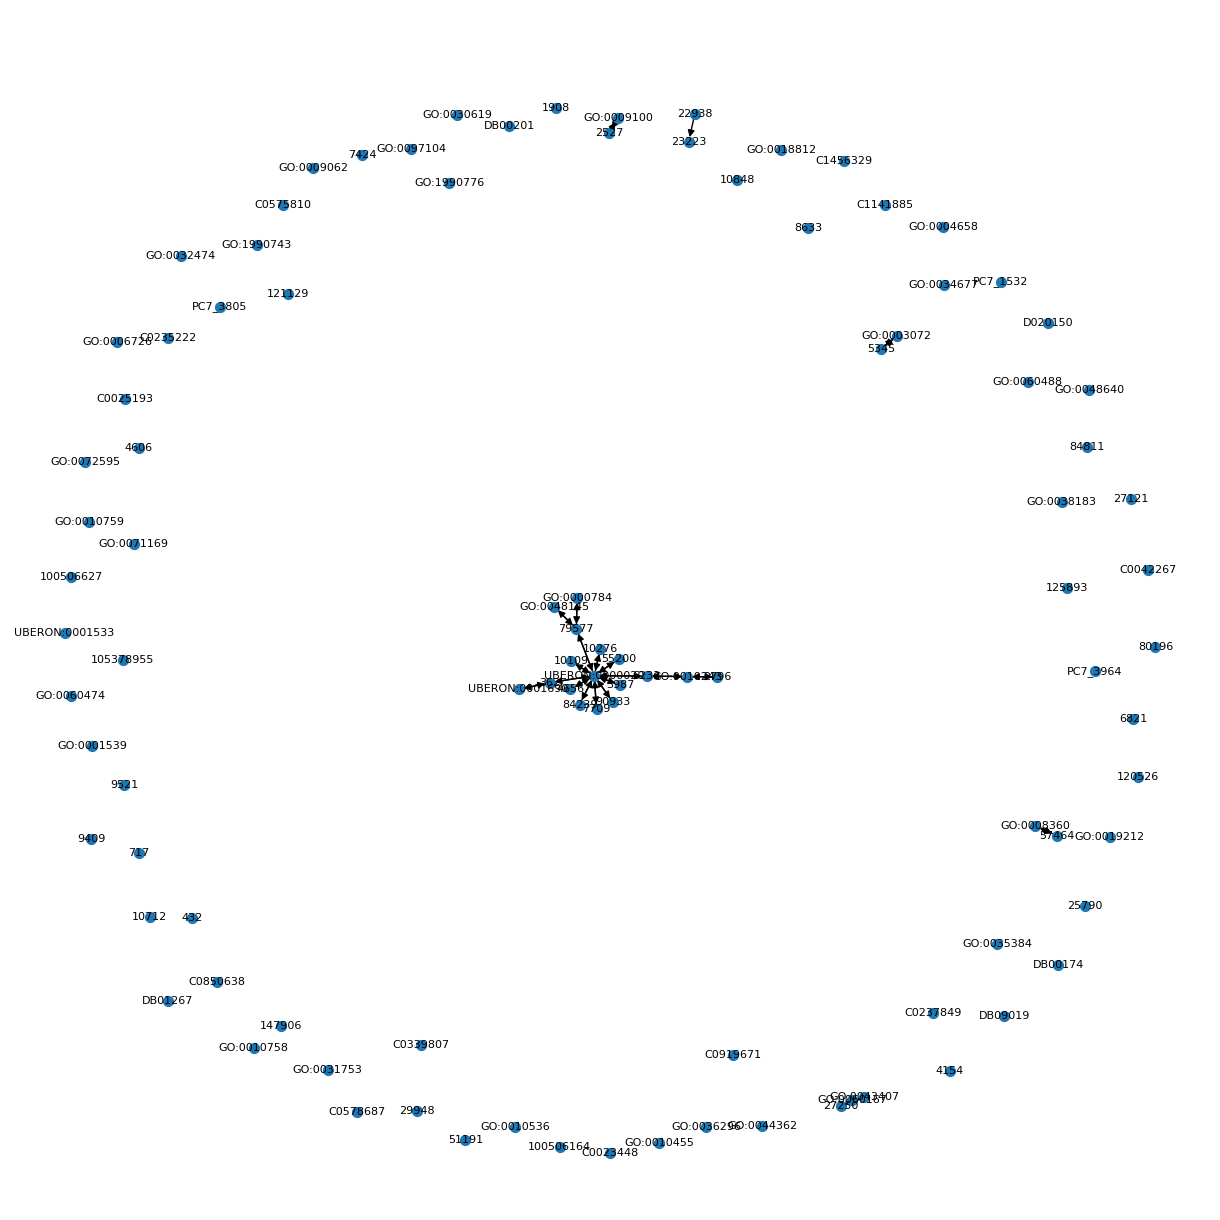

In [10]:
import matplotlib.pyplot as plt

subgraph_nodes = list(G.nodes())[:100]  # first 100 nodes
subgraph_ = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph_)
plt.figure(figsize=(12, 12))
nx.draw(subgraph_, pos, with_labels=True, node_size=50, font_size=8)
plt.show()

In [11]:
import random
import warnings
warnings.filterwarnings("ignore")



connected_components_percentage = 0.7
unconnected_component_percentage = 0.3

connected_components = list(nx.strongly_connected_components(G))
largest_connected_component = max(connected_components, key=len)

random.seed(123)
sampled_connected_nodes = set(random.sample(largest_connected_component, int(len(largest_connected_component) * connected_components_percentage)))
unconnected_nodes = set(G.nodes) - set.union(*map(set, connected_components))
sampled_unconnected_nodes = set(random.sample(unconnected_nodes, int(len(unconnected_nodes) * unconnected_component_percentage)))

sampled_nodes = sampled_connected_nodes | sampled_unconnected_nodes

sampled_edges = [(u, v) for u, v in G.edges if u in sampled_nodes and v in sampled_nodes]

H = G.subgraph(sampled_nodes).copy()
H.add_edges_from(sampled_edges)

In [12]:
print("Original number of nodes:", G.number_of_nodes())
print("Original number of edges:", G.number_of_edges())
print("Sampled number of nodes:", H.number_of_nodes())
print("Sampled number of edges:", H.number_of_edges())

Original number of nodes: 47031
Original number of edges: 3954805
Sampled number of nodes: 31609
Sampled number of edges: 1985049


In [13]:
connected_components = list(nx.weakly_connected_components(H))
num_connected_components = len(connected_components)
num_connected_components

676

- [Guilt by Association abstract](https://pubmed.ncbi.nlm.nih.gov/22479173/)

### K-CORE

- NB: This cell takes longer to run.

In [14]:
k_values = range(2, 8)
combined_k_core_nodes = set()

for k in k_values:
  k_core_subgraph = nx.k_core(H, k)
  combined_k_core_nodes.update(k_core_subgraph.nodes())

combined_k_core_subgraph = H.subgraph(combined_k_core_nodes)

print("Combined k-core subgraph nodes:", combined_k_core_subgraph.number_of_nodes())
print("Combined k-core subgraph edges:", combined_k_core_subgraph.number_of_edges())

Combined k-core subgraph nodes: 30934
Combined k-core subgraph edges: 1985049


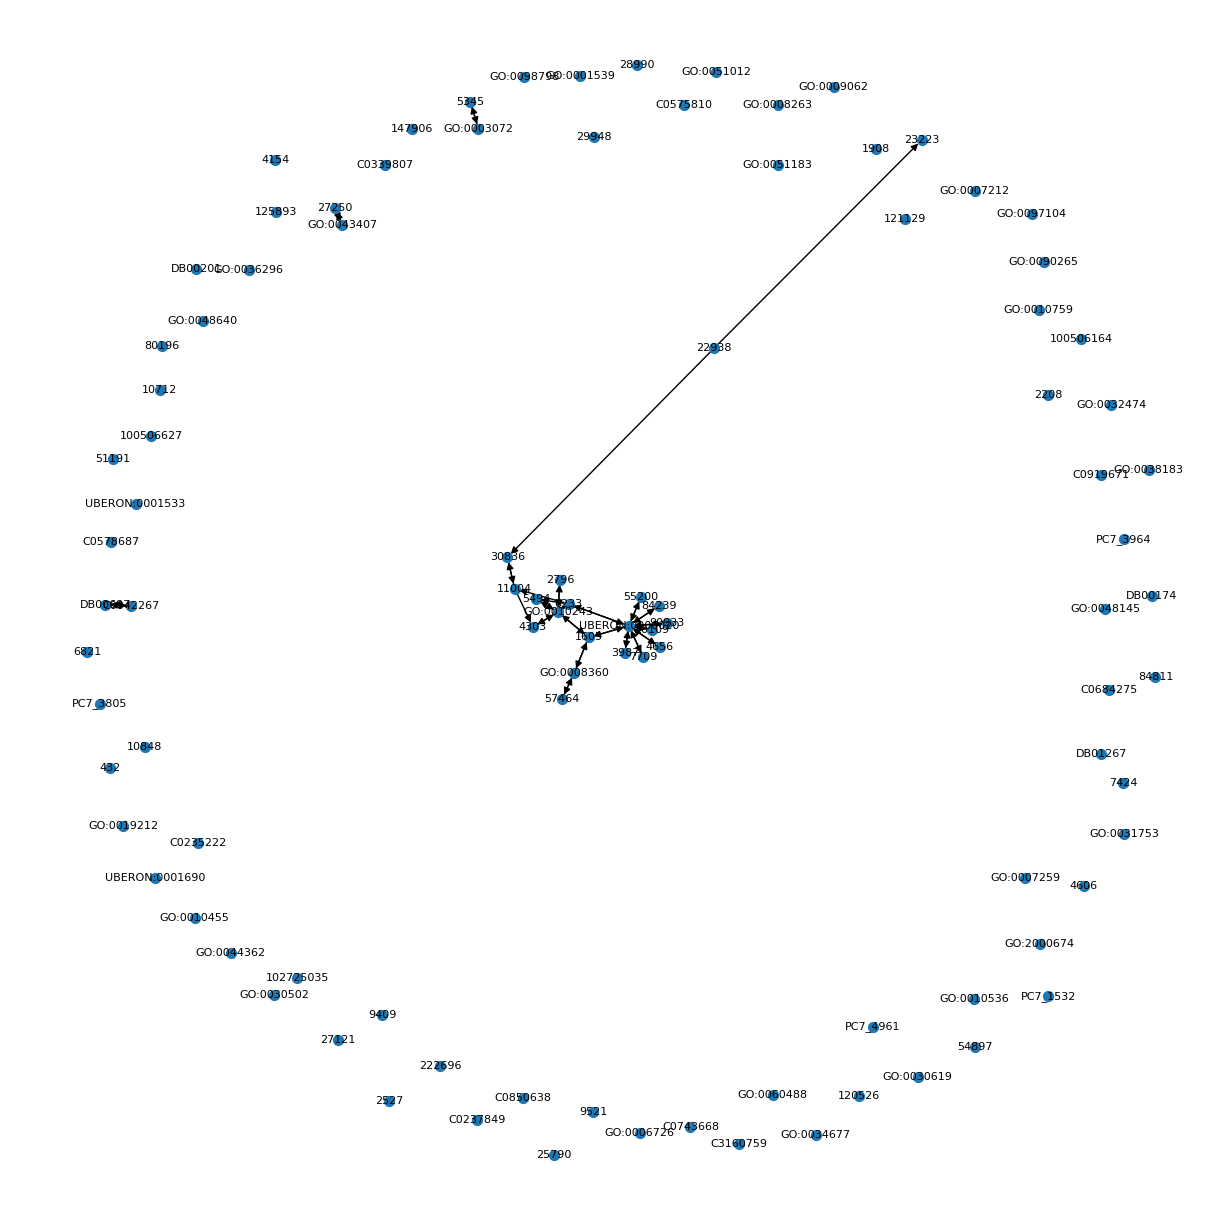

In [15]:
import matplotlib.pyplot as plt

subgraph_nodes = list(combined_k_core_subgraph.nodes())[:100]  # first 100 nodes
subgraph_ = combined_k_core_subgraph.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph_)
plt.figure(figsize=(12, 12))
nx.draw(subgraph_, pos, with_labels=True, node_size=50, font_size=8)
plt.show()

In [16]:
nodes_df.head(4)

,kind,identifier,name,data
0,Molecular Function,GO:0031753,endothelial differentiation G-protein coupled ...,"{'source': 'Gene Ontology', 'license': 'CC BY ..."
1,Side Effect,C0023448,Lymphocytic leukaemia,"{'source': 'UMLS via SIDER 4.1', 'license': 'C..."
2,Gene,5345,SERPINF2,"{'description': 'serpin peptidase inhibitor, c..."
3,Gene,9409,PEX16,{'description': 'peroxisomal biogenesis factor...


In [17]:
### node features
for _, row in nodes_df.iterrows():
  node_id = row['identifier']
  if node_id in combined_k_core_subgraph.nodes:
    combined_k_core_subgraph.nodes[node_id]['features'] = row['data'] # dict accepted for node features.

In [18]:
i = 0
for node in combined_k_core_subgraph.nodes(data=True):
  print(node)
  i += 1
  if i == 5:
    break

('GO:0031753', {'kind': 'Molecular Function', 'name': 'endothelial differentiation G-protein coupled receptor binding', 'features': {'source': 'Gene Ontology', 'license': 'CC BY 4.0', 'url': 'http://purl.obolibrary.org/obo/GO_0031753'}})
(5345, {'kind': 'Gene', 'name': 'SERPINF2', 'features': {'description': 'serpin peptidase inhibitor, clade F (alpha-2 antiplasmin, pigment epithelium derived factor), member 2', 'source': 'Entrez Gene', 'license': 'CC0 1.0', 'url': 'http://identifiers.org/ncbigene/5345', 'chromosome': '17'}})
(9409, {'kind': 'Gene', 'name': 'PEX16', 'features': {'description': 'peroxisomal biogenesis factor 16', 'source': 'Entrez Gene', 'license': 'CC0 1.0', 'url': 'http://identifiers.org/ncbigene/9409', 'chromosome': '11'}})
('GO:0032474', {'kind': 'Biological Process', 'name': 'otolith morphogenesis', 'features': {'source': 'Gene Ontology', 'license': 'CC BY 4.0', 'url': 'http://purl.obolibrary.org/obo/GO_0032474'}})
('GO:0010536', {'kind': 'Biological Process', 'nam

In [19]:
from transformers import AutoModel, AutoTokenizer

model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
import torch
import torch.nn as nn

target_dim = 128
projected_embed_layer = nn.Linear(768, target_dim)

def get_node_feature_embedding(text):
  inputs = tokenizer(text, return_tensors = 'pt', truncation = True, padding = True, max_length = 512)
  with torch.no_grad():
    outputs = model(**inputs)
  embedding = outputs.last_hidden_state.mean(dim = 1).squeeze()
  return projected_embed_layer(embedding)

- NB: This cell(below) also takes longer to run (43 mins)

In [21]:
for node_id, attr in combined_k_core_subgraph.nodes(data = True):
  text_to_encode = attr['name']
  if 'description' in attr['features']:
    text_to_encode += " " + attr['features']['description']
  embedding = get_node_feature_embedding(text_to_encode)
  combined_k_core_subgraph.nodes[node_id]['embedding'] = embedding

In [22]:
import torch
from torch_geometric.utils import from_networkx

In [23]:
pyg_data = from_networkx(combined_k_core_subgraph)
pyg_data.x = torch.stack([combined_k_core_subgraph.nodes[node_id]['embedding'] for node_id in combined_k_core_subgraph.nodes])
print(pyg_data)

Data(edge_index=[2, 1985049], kind=[30934], name=[30934], features=[30934], embedding=[30934, 128], edge_kind=[1985049], num_nodes=30934, x=[30934, 128])


### Processed and Saved K-Core subgraph for training

In [14]:
!pip install torch_geometric

In [15]:
import torch
import random
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch.nn as nn

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
graph_data = '/content/drive/MyDrive/KOBBY/Datasets/hetnet/'

# torch.save(pyg_data, graph_data + "combined_k_core_subgraph_pyg_256.pt")

#load
pyg_data_loaded = torch.load(graph_data + "combined_k_core_subgraph_pyg.pt")
print(pyg_data_loaded)

Data(edge_index=[2, 1985364], kind=[30842], name=[30842], features=[30842], embedding=[30842, 128], edge_kind=[1985364], num_nodes=30842, x=[30842, 128])


In [19]:
## This line need be run with 'TPU' runtime of google colab, it is computationally heavy here
pyg_data = train_test_split_edges(pyg_data_loaded)

In [20]:
from torch_geometric.utils import negative_sampling

if not hasattr(pyg_data, 'train_neg_edge_index'):
    pyg_data.train_neg_edge_index = negative_sampling(
        edge_index=pyg_data_loaded.train_pos_edge_index,
        num_nodes=pyg_data.num_nodes,
        num_neg_samples=pyg_data_loaded.train_pos_edge_index.size(1)
    )

if not hasattr(pyg_data, 'val_neg_edge_index'):
    pyg_data.val_neg_edge_index = negative_sampling(
        edge_index=pyg_data.val_pos_edge_index,
        num_nodes=pyg_data.num_nodes,
        num_neg_samples=pyg_data.val_pos_edge_index.size(1)
    )

if not hasattr(pyg_data, 'test_neg_edge_index'):
    pyg_data_loaded.test_neg_edge_index = negative_sampling(
        edge_index=pyg_data.test_pos_edge_index,
        num_nodes=pyg_data.num_nodes,
        num_neg_samples=pyg_data.test_pos_edge_index.size(1)
    )

In [21]:
print(hasattr(pyg_data, 'train_pos_edge_index'))
print(hasattr(pyg_data, 'train_neg_edge_index'))
print(hasattr(pyg_data, 'val_pos_edge_index'))
print(hasattr(pyg_data, 'val_neg_edge_index'))

True
True
True
True


In [22]:
class GraphSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GraphSAGE, self).__init__()
    self.conv1 = SAGEConv(in_channels, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, out_channels)

  def encode(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    return x

  def decode(self, z, edge_index):
    edge_embeddings = z[edge_index[0]] * z[edge_index[1]]
    return edge_embeddings.sum(dim = 1)

  def decode_all(self, z):
    prob_adj = torch.matmul(z, z.t())
    return prob_adj

In [23]:
def binary_cross_entropy_loss(pos_pred, neg_pred):
  pos_loss = -torch.log(pos_pred + 1e-15).mean()
  neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()
  return pos_loss + neg_loss

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.train_pos_edge_index).sigmoid()
    neg_pred = model.decode(z, data.train_neg_edge_index).sigmoid()
    loss = binary_cross_entropy_loss(pos_pred, neg_pred)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index).sigmoid()
    neg_pred = model.decode(z, data.test_neg_edge_index).sigmoid()
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    y_pred = torch.cat([pos_pred, neg_pred])
    y_true = torch.cat([pos_labels, neg_labels])
    return F.binary_cross_entropy(y_pred, y_true)

In [24]:
hidden_channels = 64
out_channels = 32

model = GraphSAGE(pyg_data_loaded.num_features, hidden_channels=hidden_channels, out_channels=out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    loss = train(model, pyg_data, optimizer)
    if epoch % 10 == 0:
        test_loss = test(model, pyg_data)
        print(f'Epoch: {epoch:01d}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch: 10, Loss: 1.4333, Test Loss: 0.7104


In [ ]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def evaluate_auc(model, data):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    pos_pred = model.decode(z, data.test_pos_edge_index).sigmoid()
    neg_pred = model.decode(z, data.test_neg_edge_index).sigmoid()
    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))
    y_pred = torch.cat([pos_pred, neg_pred]).cpu().numpy()
    y_true = torch.cat([pos_labels, neg_labels]).cpu().numpy()
    auc_score = roc_auc_score(y_true, y_pred)
    return auc_score

In [ ]:
# Calculate AUC score for test data
auc_score = evaluate_auc(model, pyg_data)
print(f'Test AUC Score: {auc_score:.4f}')

- Changing `lr` from 0.003 to 0.001 increased performance from 0.72+ to 0.76+

In [ ]:
# Calculate AUC score for test data
auc_score = evaluate_auc(model, pyg_data)
print(f'Test AUC Score: {auc_score:.4f}')

Test AUC Score: 0.7225


- Changing `lr` from `0.01` to `0.003` increased performance from `0.51+` to `0.72+`

In [ ]:
# Calculate AUC score for test data
auc_score = evaluate_auc(model, pyg_data)
print(f'Test AUC Score: {auc_score:.4f}')

Test AUC Score: 0.5124


- First training `Test AUC Score: 0.5113` wiht `lr = 0.01`

In [10]:
model_save_path =  "/content/drive/MyDrive/KOBBY/Datasets/hetnet/model/" + "hetnet_model_one.pth"
#torch.save(model.state_dict(), model_save_path)

In [11]:
## Re-initialize
hidden_channels = 64
out_channels = 32
model = GraphSAGE(in_channels=pyg_data_loaded.num_features, hidden_channels=hidden_channels, out_channels=out_channels)

model.load_state_dict(torch.load(model_save_path))
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


In [12]:
from torch_geometric.utils import negative_sampling

candidate_non_links = negative_sampling(
                      edge_index=pyg_data_loaded.edge_index,
                      num_nodes=pyg_data_loaded.num_nodes,
                      num_neg_samples=50000
                      )
candidate_non_links

tensor([[28601, 10687, 27818,  ...,  7093,  1448,  5375],
        [21574, 20124,  5145,  ..., 19833, 22651, 28213]])

In [13]:
node_embeddings = model.encode(pyg_data_loaded.x, pyg_data_loaded.edge_index)
link_probs = model.decode(node_embeddings, candidate_non_links).sigmoid()

In [15]:
threshold = 0.8
predicted_new_links = candidate_non_links[:, link_probs > threshold]
predicted_scores = link_probs[link_probs > threshold]

for i, (node_pair, score) in enumerate(zip(candidate_non_links.t().tolist(), predicted_scores.tolist())):
    print(f"Predicted link between nodes {node_pair[0]} and {node_pair[1]} with score {score:.4f}")

    if i == 20:
      break

Predicted link between nodes 28601 and 21574 with score 0.8029
Predicted link between nodes 10687 and 20124 with score 0.8096
Predicted link between nodes 27818 and 5145 with score 0.8239
Predicted link between nodes 795 and 3569 with score 0.8111
Predicted link between nodes 1443 and 11288 with score 0.8361
Predicted link between nodes 1328 and 17184 with score 0.8080
Predicted link between nodes 8135 and 4049 with score 0.8151
Predicted link between nodes 18389 and 17281 with score 0.8223
Predicted link between nodes 12347 and 21564 with score 0.8056
Predicted link between nodes 11937 and 12292 with score 0.8148
Predicted link between nodes 734 and 24215 with score 0.8017
Predicted link between nodes 10338 and 13770 with score 0.8164
Predicted link between nodes 17508 and 3822 with score 0.8105
Predicted link between nodes 22617 and 21000 with score 0.8460
Predicted link between nodes 21977 and 338 with score 0.8072
Predicted link between nodes 21043 and 19006 with score 0.8281
Predi

In [ ]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve
import networkx as nx
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred, graph, predicted_edges, threshold=0.5):
    """
    Compute precision, recall, AUPRC, and graph connectivity improvement.

    Parameters:
        y_true (list): Ground truth labels (1 for edge, 0 for non-edge).
        y_pred (list): Predicted probabilities or scores for edges.
        graph (networkx.Graph): Original graph.
        predicted_edges (list of tuples): Predicted edges as (node1, node2).
        threshold (float): Threshold for classifying edges as present.

    Returns:
        dict: Dictionary containing precision, recall, AUPRC, and graph sparsity improvement.
    """
    ## Threshold predictions to binary labels
    y_pred_binary = [1 if p >= threshold else 0 for p in y_pred]

    # Compute Precision and Recall
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)

    # Compute AUPRC
    auprc = average_precision_score(y_true, y_pred)

    ### Plot Precision-Recall Curve
    precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, label=f"AUPRC = {auprc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

    ## Compute Graph Connectivity Improvement
    original_sparsity = 1 - (len(graph.edges) / (len(graph.nodes) * (len(graph.nodes) - 1) / 2))

    #### Add predicted edges to graph
    predicted_graph = graph.copy()
    predicted_graph.add_edges_from(predicted_edges)

    new_sparsity = 1 - (len(predicted_graph.edges) / (len(predicted_graph.nodes) * (len(predicted_graph.nodes) - 1) / 2))
    connectivity_improvement = original_sparsity - new_sparsity

    return {
        "Precision": precision,
        "Recall": recall,
        "AUPRC": auprc,
        "Original Sparsity": original_sparsity,
        "New Sparsity": new_sparsity,
        "Connectivity Improvement": connectivity_improvement
    }

In [11]:
pos_edges = pyg_data.val_pos_edge_index
neg_edges = pyg_data.val_neg_edge_index

# Ground truth labels: 1 for positive edges, 0 for negative edges
y_true = [1] * pos_edges.size(1) + [0] * neg_edges.size(1)

# Generate predictions for both positive and negative edges
pos_preds = model.decode(model.encode(pyg_data.x, pos_edges), pos_edges).sigmoid().detach().numpy()
neg_preds = model.decode(model.encode(pyg_data.x, neg_edges), neg_edges).sigmoid().detach().numpy()
y_pred = list(pos_preds) + list(neg_preds)

([0.8918322,
  0.92516845,
  0.91739255,
  0.93582165,
  0.9154604,
  0.9275602,
  0.9282282,
  0.930887,
  0.89769423,
  0.90048397],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

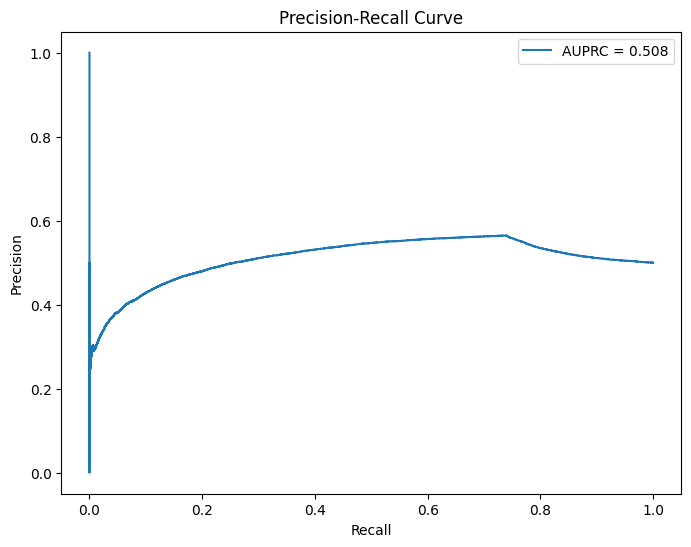

Precision: 0.500
Recall: 1.000
AUPRC: 0.508


In [12]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

# Compute Precision and Recall
precision = precision_score(y_true, [1 if p >= 0.5 else 0 for p in y_pred])
recall = recall_score(y_true, [1 if p >= 0.5 else 0 for p in y_pred])

# Compute AUPRC
auprc = average_precision_score(y_true, y_pred)

# Plot Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label=f"AUPRC = {auprc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"AUPRC: {auprc:.3f}")

In [13]:
import networkx as nx

original_graph = nx.Graph()
original_graph.add_edges_from(pyg_data.train_pos_edge_index.T.tolist())

predicted_edges = [(int(edge[0]), int(edge[1])) for edge, pred in zip(
    pos_edges.T.tolist() + neg_edges.T.tolist(), y_pred) if pred > 0.8]

##Create a new graph with predicted edges
predicted_graph = original_graph.copy()
predicted_graph.add_edges_from(predicted_edges)

#Compute sparsity before and after adding predicted edges
original_sparsity = 1 - (len(original_graph.edges) / (len(original_graph.nodes) * (len(original_graph.nodes) - 1) / 2))
new_sparsity = 1 - (len(predicted_graph.edges) / (len(predicted_graph.nodes) * (len(predicted_graph.nodes) - 1) / 2))
connectivity_improvement = original_sparsity - new_sparsity

print(f"Original Sparsity: {original_sparsity:.6f}")
print(f"New Sparsity: {new_sparsity:.6f}")
print(f"Connectivity Improvement: {connectivity_improvement:.6f}")

Original Sparsity: 0.998174
New Sparsity: 0.998067
Connectivity Improvement: 0.000107
